# Pair Trading With Cryptocurrencies

## How To Implement A Pair Trading Strategy Using Python

## Introduction
...

## Implementing A Pair Trading Strategy
### Step By Step
1. Load data
2. Implement strat
3. Performance analysis

You can find the code on https://github.com/DinodC/pair-trading-cryptos.

Import packages

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from pandas import Series, DataFrame

In [4]:
import pickle

In [5]:
import matplotlib.pyplot as plt

In [6]:
import statsmodels.api as sm

In [7]:
%matplotlib inline

## Load Data

Load cryptocurrency data

In [8]:
with open('data_coinmarketcap.pickle', 'rb') as f:
    data = pickle.load(f)
    
f.close()

Create closing prices DataFrame object

In [9]:
close = pd.DataFrame({'BTC': data.BTC.Close,
                      'ETH': data.ETH.Close,
                      'LTC': data.LTC.Close,
                      'XRP': data.XRP.Close})

Create id list

In [10]:
id = ['BTC', 'ETH', 'LTC', 'XRP']

Plot

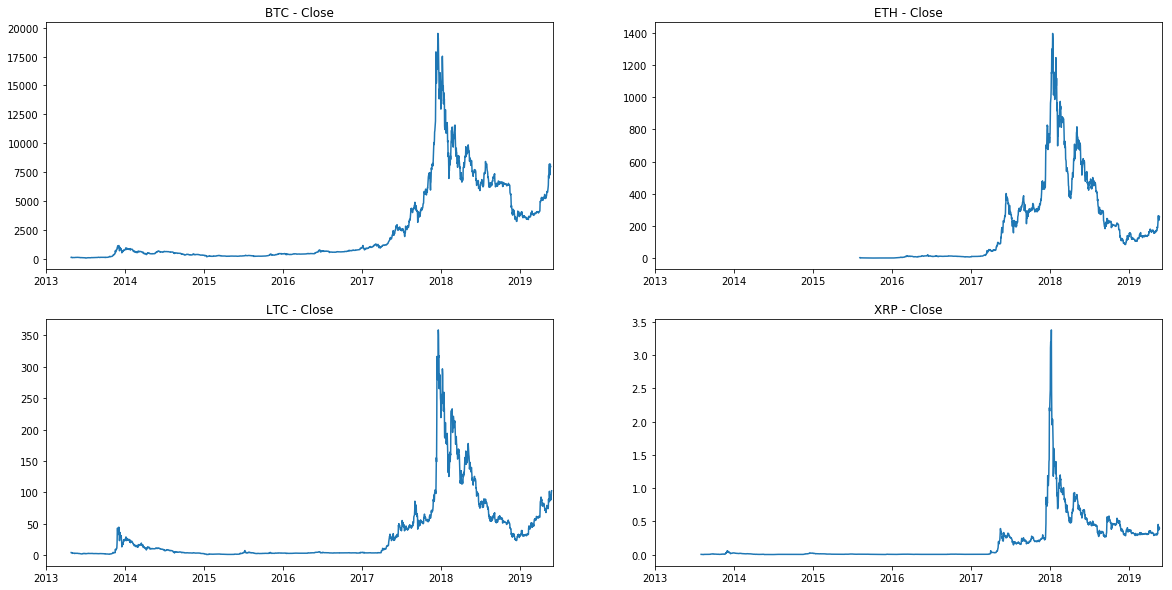

In [11]:
plt.figure(figsize=[20, 10])

for i in range(1, len(id)+1):    
    plt.subplot(2, 2, i)
    plt.plot(close[id[i-1]])
    plt.title(id[i-1] + ' - Close')
    plt.xlim('2013-01-01', '2019-06-01')


Note that ETH historical data is only available from July 2015 onwards.

## Pair Trading Strategy
The investment system is inspired from [E. Chan's](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889/ref=sr_1_1?crid=39RKR1QE7L1BS&keywords=quantitative+trading&qid=1558788312&s=gateway&sprefix=quantitativ%2Caps%2C500&sr=8-1) pair trading strategy involving gold and gold index ETFs. The rules of the strateg are the following:
- Enter a long position if it is below -1 STD.
- Enter a short position if the spread is above 1 STD.
- Exit the position if it is in greater than -0.5 and less than 0.5 STD.

In [12]:
# Define entry and exit thresholds
entry_threshold = 1
exit_threshold = 0.5

### Correct For Data-snooping Bias

Data-snooping bias is inflating a trading strategy's performance in the backtesting process. It can be due to overfitting a model by increasing the number of parameters to optimize backtesting performance. Data-snooping can also be caused by optimizing decisions in the trading strategy such as determining entry and exit levels, or choosing between small and large-cap stocks.

To mitigate for data-snooping bias, we can do the following:
1. Out-of-sample testing: 
Out-of-sample testing involves separating historical data into a training and test set. We optimize the model's parameters using the training set. We run the model on the test or out-of-sample set.
2. Paper trading:
Paper trading and out-of-sample testing share the same idea of data segragation. We optimize the model's parameters using historical data. We run the model using actual data. 

In this article, we only apply out-of-sample testing to remedy data-snooping bias.

In [13]:
# Define training set
training_start = '2015-08-07'
training_end = '2017-08-01'
training_set = close[training_start:training_end]

# Define test set
test_start = '2017-08-02'
test_end = '2019-05-21'
test_set = close[test_start:test_end]

### Correct For Look-ahead Bias
Look-ahead bias is using trading signal based on information not yet available at the time of the trade.
An example is using regression coefficients of a linear regression of price series.
The price series are not available on any given trading day.

To control for look-ahead bias, we can do the following:
1. Backtest using historical data and save the positions.
2. Backtest using truncated historical data, e.g. 10 days, and save the positions.
3. Truncate the positions from point 1, e.g. 10 days, compare with the positions from point 2.

In this article, we implement the above procedure to check for look-ahead bias.

### Include Transaction Costs
- what?
- assume one way tc of 5 BPs
- every time we long, short or exit we lose 10 BPs

In [14]:
# One way transaction cost
one_way = 0.0005

### Complete Implementation

In [15]:
# Set crypto 1 to BTC
crypto_1 = id[0]

# Initialize output
output = {id[1]: {},
          id[2]: {}, 
          id[3]: {}}

for i in range(1, len(id)):
    
    # Set crypto 2 to ETH, LTC and XRP
    crypto_2 = id[i]
    
    # Calculate the hedge ratio using the training set
    model = sm.OLS(training_set[crypto_1], training_set[crypto_2])
    result = model.fit()
    hedge_ratio = result.params[crypto_2]

    # Calculate the spread
    spread = close[crypto_1] - hedge_ratio * close[crypto_2]
    # Mean of the spread on the training set
    spread_mean = spread[training_start:training_end].mean()
    # Standard deviation of the spread calculated on the training set
    spread_std = spread[training_start:training_end].std()
    # Z-score of the spread
    z_score = (spread - spread_mean) / spread_std
    
    # Implement pair trading strategy
    # Create masks for long, short and exit positions
    longs = (z_score <= -entry_threshold)
    shorts = (z_score >= entry_threshold)
    exits = (np.abs(z_score) <= exit_threshold)
    # Initialize the positions
    positions = pd.DataFrame({crypto_1: np.nan * pd.Series(range(len(z_score))),
                              crypto_2: np.nan * pd.Series(range(len(z_score)))},
                             index=z_score.index)
    # Update the positions
    [positions[crypto_1][longs], positions[crypto_2][longs]] = [1, -1]
    [positions[crypto_1][shorts], positions[crypto_2][shorts]] = [-1, 1]
    [positions[crypto_1][exits], positions[crypto_2][exits]] = [0, 0]
    # Carry foward the positions except when there is an exit
    positions.fillna(method='ffill', inplace=True)
    # Lag the positions to the next day because we base calculations on close
    positions = positions.shift(periods=1)
    
    # Calculate the performance
    # Initialize the returns
    returns = pd.DataFrame({crypto_1: close[crypto_1],
                            crypto_2: close[crypto_2]})
    # Update the returns
    returns = returns.pct_change()
    # Calculate the pnl
    pnl = returns * positions

    # Calculate transaction costs
    # Create a mask to indicate changes in position
    mask = (~np.isnan(positions.BTC) & (positions.BTC - positions.BTC.shift(periods=1)).astype(bool))
    # mask = (~np.isnan(positions.BTC) & (positions.BTC != positions.BTC.shift(periods=1)))
    # Create a transaction costs Series
    tc = pd.Series(np.zeros(len(mask)), index=mask.index)
    tc[mask] = -2 * one_way
    
    # Update pnl DataFrame
    pnl['TC'] = tc
    # Calculate net pnl
    pnl_net = pnl.sum(axis='columns')
    
    # Calculate the Sharpe ratio under the training set
    sharpe_training = np.sqrt(252) * pnl_net[training_start:training_end].mean() / pnl_net[training_start:training_end].std()
    # Calculate the Sharpe ratio under the test set
    sharpe_test = np.sqrt(252) * pnl_net[test_start:test_end].mean() / pnl_net[test_start:test_end].std()
            
    # Generate the output
    # Gather data
    data = {'spread': z_score,
            'positions': positions,
            'pnl': pnl_net,
            'sharpe training': sharpe_training,
            'sharpe test': sharpe_test,
           }
    # Update the output
    output.update({crypto_2: data})
    

## Performance Analysis

### Spread

Plot

(-50, 50)

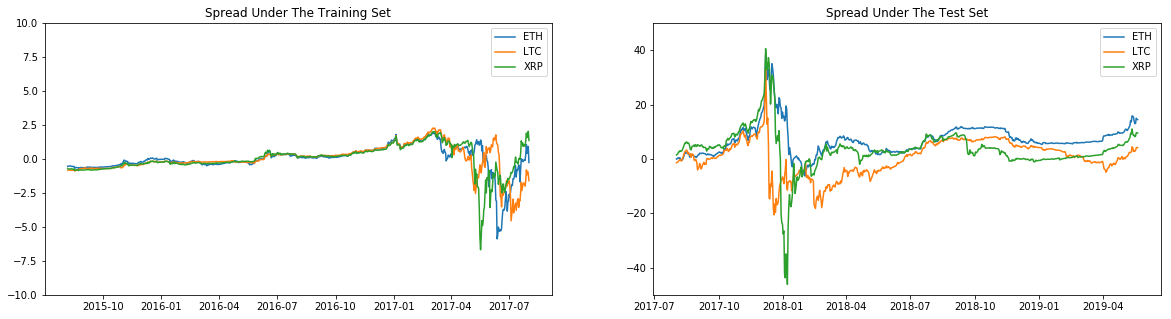

In [25]:
plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(output['ETH']['spread'][training_start:training_end])
plt.plot(output['LTC']['spread'][training_start:training_end])
plt.plot(output['XRP']['spread'][training_start:training_end])
plt.title('Spread Under The Training Set')
plt.legend(['ETH', 'LTC', 'XRP'])
plt.ylim(-10, 10)
plt.subplot(1, 2, 2)
plt.plot(output['ETH']['spread'][test_start:test_end])
plt.plot(output['LTC']['spread'][test_start:test_end])
plt.plot(output['XRP']['spread'][test_start:test_end])
plt.title('Spread Under The Test Set')
plt.legend(['ETH', 'LTC', 'XRP'])
plt.ylim(-50, 50)

Remarks:
- ...
- ...
- ...

### Sharpe Ratio

Table

In [17]:
sharpe = pd.DataFrame({'BTC & ETH': [output['ETH']['sharpe training'], output['ETH']['sharpe test']],
                       'BTC & LTC': [output['LTC']['sharpe training'], output['LTC']['sharpe test']],
                       'BTC & XRP': [output['XRP']['sharpe training'], output['XRP']['sharpe test']]},
                      index=pd.MultiIndex.from_product([['Sharpe Ratio'], ['Training Set', 'Test Set']]))

In [18]:
sharpe

BTC & ETH  BTC & LTC  BTC & XRP
Sharpe Ratio Training Set   1.817663   1.175902   1.272301
             Test Set      -0.200709   0.782145   0.480900

Remarks:
- ...
- ...
- ...

### PnL

Plot

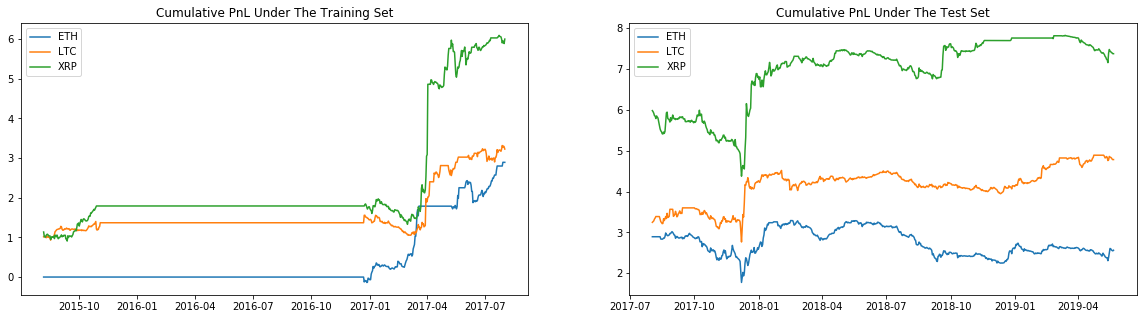

In [20]:
plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(output['ETH']['pnl'].cumsum()[training_start:training_end])
plt.plot(output['LTC']['pnl'].cumsum()[training_start:training_end])
plt.plot(output['XRP']['pnl'].cumsum()[training_start:training_end])
plt.title('Cumulative PnL Under The Training Set')
plt.legend(['ETH', 'LTC', 'XRP'])
# plt.ylim(-0.5, 3)

plt.subplot(1, 2, 2)
plt.plot(output['ETH']['pnl'].cumsum()[test_start:test_end])
plt.plot(output['LTC']['pnl'].cumsum()[test_start:test_end])
plt.plot(output['XRP']['pnl'].cumsum()[test_start:test_end])
plt.title('Cumulative PnL Under The Test Set')
plt.legend(['ETH', 'LTC', 'XRP'])
# plt.ylim(-0.5, 3)

Remarks:
- ...
- ...
- ...

## Conclusion

### Review The Main Takeaways
...

### Provide A Preview Of What Is Next (If There Is One)
...